In [1]:
from pathlib import Path
import torch
import numpy as np
from PIL import Image
from rtnls_inference import SegmentationEnsemble

c:\Users\Tiger\anaconda3\envs\vascx\lib\site-packages\lightning\fabric\__init__.py:40: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
c:\Users\Tiger\anaconda3\envs\vascx\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Segmentation of preprocessed images

Here we segment images preprocessed using 0_preprocess.ipynb


In [2]:
ds_path = Path("../data/LES-AV")

# input folders. these are the folders where we stored the preprocessed images
rgb_path = ds_path / "rgb"
ce_path = ds_path / "ce"

# these are the output folders for:
av_path = ds_path / "av"  # artery-vein segmentations (original combined)
arteries_path = ds_path / "arteries"  # artery binary masks
veins_path = ds_path / "veins"  # vein binary masks
discs_path = ds_path / "discs"  # optic disc segmentations
overlays_path = ds_path / "overlays"  # optional overlay visualizations

device = torch.device("cuda:0")  # device to use for inference

In [3]:
rgb_paths = sorted(list(rgb_path.glob("*.png")))
ce_paths = sorted(list(ce_path.glob("*.png")))
paired_paths = list(zip(rgb_paths, ce_paths))

In [4]:
paired_paths[0]  # important to make sure that the paths are paired correctly
# Note: While we have paired RGB and CE paths, the segmentation models expect only RGB paths
# as they handle contrast enhancement internally to avoid applying it twice.

(WindowsPath('../data/LES-AV/rgb/111.png'),
 WindowsPath('../data/LES-AV/ce/111.png'))

### Artery-vein segmentation


In [5]:
av_ensemble = SegmentationEnsemble.from_huggingface('Eyened/vascx:artery_vein/av_july24.pt').to(device)

# Use only RGB paths for AV segmentation, since the model handles contrast enhancement internally
av_ensemble.predict_preprocessed(rgb_paths, dest_path=av_path, num_workers=2)

# NEW: Save separate artery and vein masks directly during inference
import sys
sys.path.append('..')
from vascx_models.inference import run_segmentation_vessels_and_av

print("Running AV segmentation with separate artery and vein masks...")

# This will save separate binary masks for arteries and veins directly, 
# without needing to decompose the combined AV mask later
run_segmentation_vessels_and_av(
    rgb_paths=rgb_paths,
    arteries_path=arteries_path,
    veins_path=veins_path,
    av_path=av_path,  # This is optional now if you only want separate masks
    vessels_path=None,  # Not running vessel segmentation here
    devices=[0] if device.type == 'cuda' else None
)

print(f"Saved {len(list(arteries_path.glob('*.png')))} artery masks and {len(list(veins_path.glob('*.png')))} vein masks directly")

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\Tiger\anaconda3\envs\vascx\lib\site-packages\monai\inferers\utils.py:220: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
c:\Users\Tiger\anaconda3\envs\vascx\lib\site-packages\monai\inferers\utils.py:354: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a differe

Running AV segmentation with separate artery and vein masks...


100%|██████████| 3/3 [00:19<00:00,  6.36s/it]

Saved 22 artery masks and 22 vein masks directly


### Disc segmentation


In [6]:
disc_ensemble = SegmentationEnsemble.from_huggingface('Eyened/vascx:disc/disc_july24.pt').to(device)
# Use only RGB paths for disc segmentation, since the model handles contrast enhancement internally
disc_ensemble.predict_preprocessed(rgb_paths, dest_path=discs_path, num_workers=2)

# Convert disc segmentations to binary masks
print("Converting disc segmentations to binary masks...")

for disc_file in discs_path.glob("*.png"):
    image_id = disc_file.stem
    disc_mask = np.array(Image.open(disc_file))
    
    # Disc segmentation typically has classes: 0=background, 1=disc
    # Create binary mask for disc (class 1)
    binary_disc_mask = (disc_mask > 0).astype(np.uint8) * 255
    
    # Save as binary PNG mask (overwrite the original)
    Image.fromarray(binary_disc_mask).save(disc_file)
    
    print(f"Converted {image_id} to binary mask")

print(f"Converted {len(list(discs_path.glob('*.png')))} disc masks to binary")

100%|██████████| 3/3 [00:08<00:00,  2.90s/it]

Converting disc segmentations to binary masks...
Converted 111 to binary mask
Converted 119 to binary mask
Converted 12 to binary mask
Converted 15 to binary mask
Converted 224 to binary mask
Converted 240 to binary mask
Converted 275 to binary mask
Converted 279 to binary mask
Converted 304 to binary mask
Converted 318 to binary mask
Converted 33 to binary mask
Converted 34 to binary mask
Converted 367 to binary mask
Converted 37 to binary mask
Converted 370 to binary mask
Converted 42 to binary mask
Converted 486 to binary mask
Converted 49 to binary mask
Converted 529 to binary mask
Converted 53 to binary mask
Converted 586 to binary mask
Converted 90 to binary mask
Converted 22 disc masks to binary


### Plotting the retinas (optional)

This will only work if you ran all the models and stored the outputs using the same folder/file names as above


Generating visualization of segmentation results...


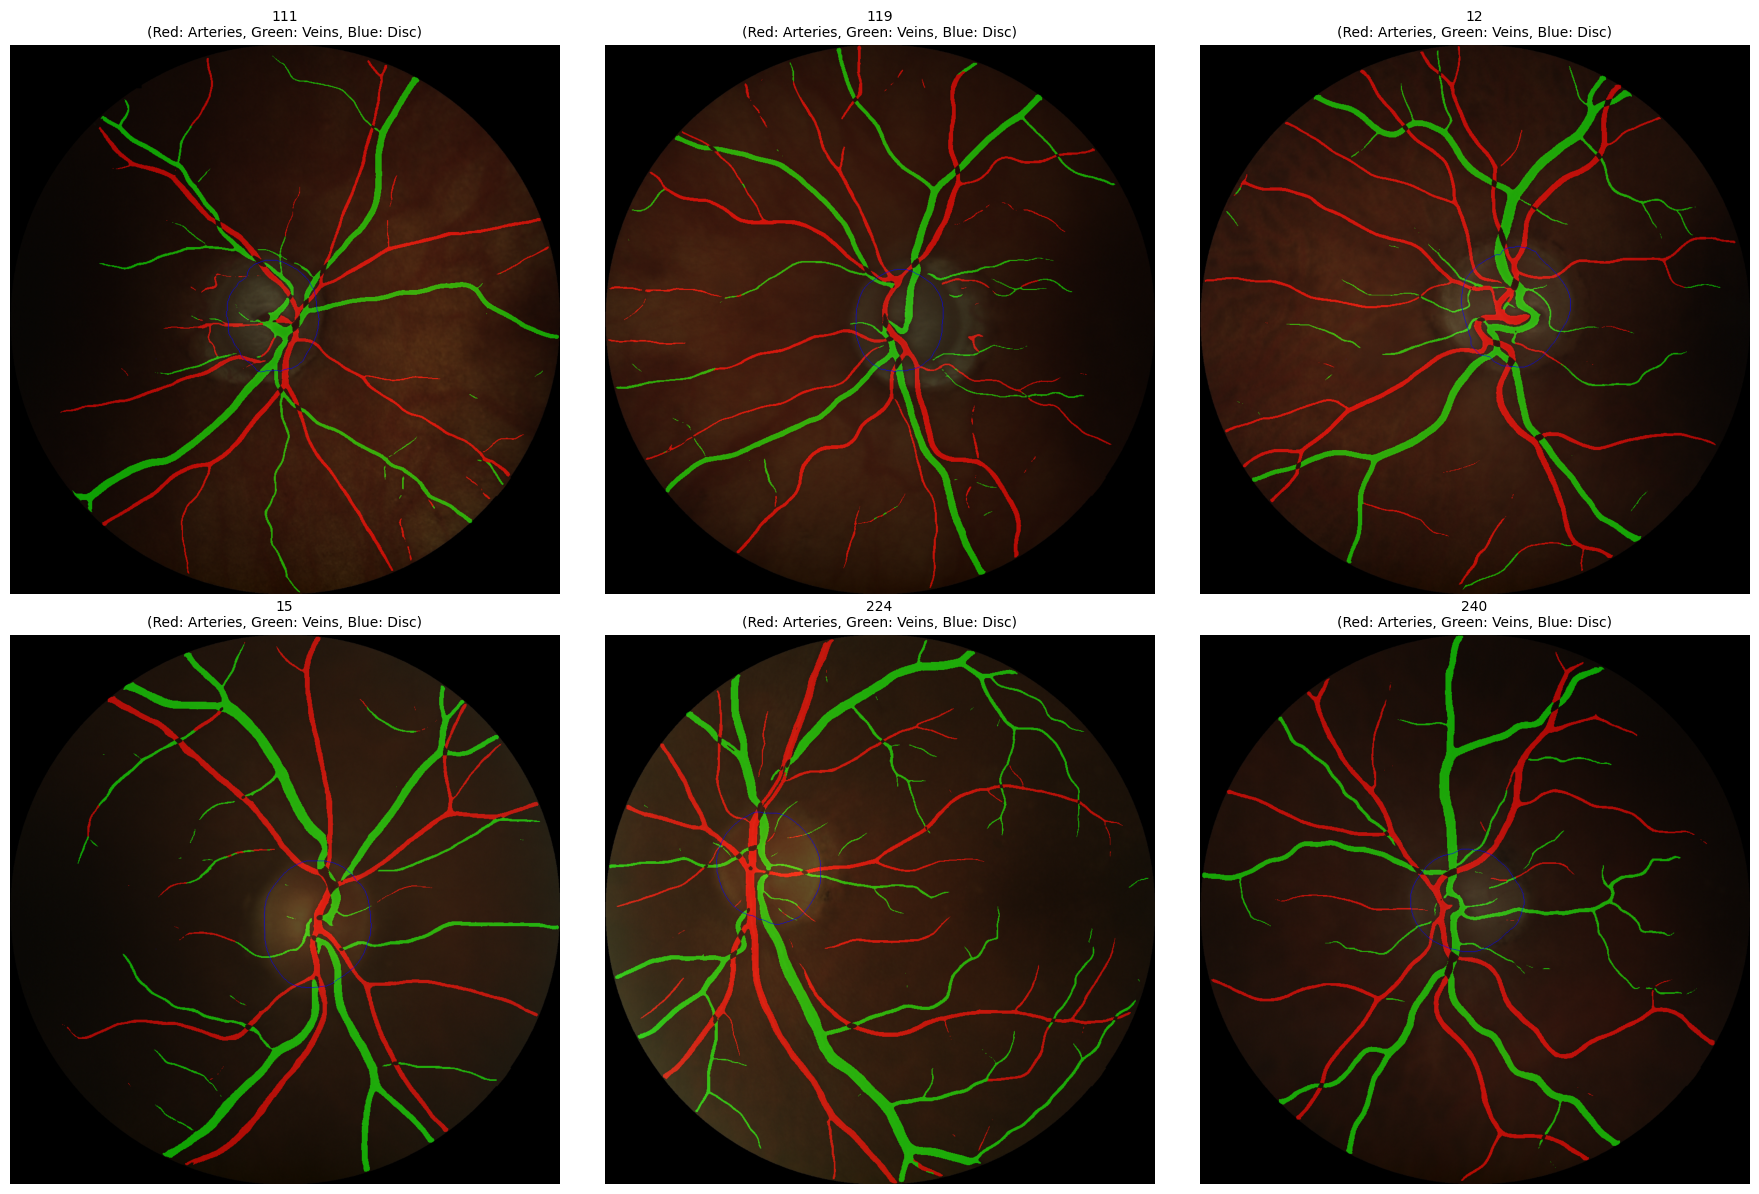

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def plot_segmentation_results():
    """Plot a grid of segmentation results with separate artery and vein masks."""
    # Get the first 6 images
    sample_rgb_paths = rgb_paths[:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, rgb_path in enumerate(sample_rgb_paths):
        if i >= 6:
            break
            
        image_id = rgb_path.stem
        
        # Load original image
        rgb_image = np.array(Image.open(rgb_path))
        
        # Create a colored overlay combining arteries and veins
        artery_path_img = arteries_path / f"{image_id}.png"
        vein_path_img = veins_path / f"{image_id}.png"
        
        if artery_path_img.exists() and vein_path_img.exists():
            artery_mask = np.array(Image.open(artery_path_img)) > 0  # Binary mask
            vein_mask = np.array(Image.open(vein_path_img)) > 0  # Binary mask
            
            # Create RGB overlay
            overlay = np.zeros_like(rgb_image)
            overlay[artery_mask] = [255, 0, 0]  # Arteries in red
            overlay[vein_mask] = [0, 255, 0]    # Veins in green
            
            # Blend overlay with original image
            alpha = 0.6
            result = (1 - alpha) * rgb_image + alpha * overlay
            result = np.clip(result, 0, 255).astype(np.uint8)
            
            # Add disc contour if available
            disc_path_img = discs_path / f"{image_id}.png"
            if disc_path_img.exists():
                disc_mask = np.array(Image.open(disc_path_img)) > 0
                # Draw disc contour in blue
                from scipy import ndimage
                disc_contour = ndimage.binary_erosion(disc_mask) != disc_mask
                result[disc_contour] = [0, 0, 255]
        else:
            result = rgb_image
        
        axes[i].imshow(result)
        axes[i].set_title(f"{image_id}\n(Red: Arteries, Green: Veins, Blue: Disc)", fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Generating visualization of segmentation results...")
plot_segmentation_results()

### Storing visualizations (optional)


In [8]:
# Create overlay visualizations for all images
print("Creating overlay visualizations for all images...")

if not overlays_path.exists():
    overlays_path.mkdir(exist_ok=True, parents=True)

from scipy import ndimage

for rgb_path in rgb_paths:
    image_id = rgb_path.stem
    
    # Load original image
    rgb_image = np.array(Image.open(rgb_path))
    
    # Check if segmentation masks exist
    artery_path_img = arteries_path / f"{image_id}.png"
    vein_path_img = veins_path / f"{image_id}.png"
    disc_path_img = discs_path / f"{image_id}.png"
    
    if artery_path_img.exists() and vein_path_img.exists():
        # Create overlay
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Original RGB image
        axes[0].imshow(rgb_image)
        axes[0].set_title(f"Original: {image_id}")
        axes[0].axis('off')
        
        # Artery mask
        artery_mask = np.array(Image.open(artery_path_img))
        axes[1].imshow(artery_mask, cmap='Reds')
        axes[1].set_title("Artery Mask")
        axes[1].axis('off')
        
        # Vein mask
        vein_mask = np.array(Image.open(vein_path_img))
        axes[2].imshow(vein_mask, cmap='Greens')
        axes[2].set_title("Vein Mask")
        axes[2].axis('off')
        
        # Combined overlay
        overlay = np.zeros_like(rgb_image)
        overlay[artery_mask > 0] = [255, 0, 0]  # Arteries in red
        overlay[vein_mask > 0] = [0, 255, 0]    # Veins in green
        
        # Add disc if available
        if disc_path_img.exists():
            disc_mask = np.array(Image.open(disc_path_img)) > 0
            try:
                disc_contour = ndimage.binary_erosion(disc_mask) != disc_mask
                overlay[disc_contour] = [0, 0, 255]  # Disc contour in blue
            except:
                # If scipy fails, just skip the disc contour
                pass
        
        # Blend with original
        alpha = 0.6
        combined = (1 - alpha) * rgb_image + alpha * overlay
        combined = np.clip(combined, 0, 255).astype(np.uint8)
        
        axes[3].imshow(combined)
        axes[3].set_title("Combined Overlay")
        axes[3].axis('off')
        
        plt.tight_layout()
        
        # Save overlay
        overlay_file = overlays_path / f"{image_id}.png"
        plt.savefig(overlay_file, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.close()
        
        print(f"Created overlay for {image_id}")
    else:
        print(f"Skipping {image_id} - segmentation masks not found")

print(f"\nOverlay creation complete. Files saved to: {overlays_path}")

# Summary of created files
print("=" * 60)
print("SEGMENTATION SUMMARY")
print("=" * 60)

# Count files in each directory
n_rgb = len(rgb_paths)
n_arteries = len(list(arteries_path.glob("*.png"))) if arteries_path.exists() else 0
n_veins = len(list(veins_path.glob("*.png"))) if veins_path.exists() else 0
n_discs = len(list(discs_path.glob("*.png"))) if discs_path.exists() else 0
n_overlays = len(list(overlays_path.glob("*.png"))) if overlays_path.exists() else 0

print(f"Original RGB images: {n_rgb}")
print(f"Artery binary masks: {n_arteries}")
print(f"Vein binary masks: {n_veins}")
print(f"Disc binary masks: {n_discs}")
print(f"Overlay visualizations: {n_overlays}")

print("\nOutput folders:")
print(f"  - Arteries: {arteries_path}")
print(f"  - Veins: {veins_path}")
print(f"  - Discs: {discs_path}")
print(f"  - Overlays: {overlays_path}")

print("\nFile format:")
print("  - Artery masks: Binary PNG (0=background, 255=artery)")
print("  - Vein masks: Binary PNG (0=background, 255=vein)")
print("  - Disc masks: Binary PNG (0=background, 255=disc)")
print("  - Overlays: RGB PNG with colored segmentations")

Creating overlay visualizations for all images...
Created overlay for 111
Created overlay for 119
Created overlay for 12
Created overlay for 15
Created overlay for 224
Created overlay for 240
Created overlay for 275
Created overlay for 279
Created overlay for 304
Created overlay for 318
Created overlay for 33
Created overlay for 34
Created overlay for 367
Created overlay for 37
Created overlay for 370
Created overlay for 42
Created overlay for 486
Created overlay for 49
Created overlay for 529
Created overlay for 53
Created overlay for 586
Created overlay for 90

Overlay creation complete. Files saved to: ..\data\LES-AV\overlays
SEGMENTATION SUMMARY
Original RGB images: 22
Artery binary masks: 22
Vein binary masks: 22
Disc binary masks: 22
Overlay visualizations: 22

Output folders:
  - Arteries: ..\data\LES-AV\arteries
  - Veins: ..\data\LES-AV\veins
  - Discs: ..\data\LES-AV\discs
  - Overlays: ..\data\LES-AV\overlays

File format:
  - Artery masks: Binary PNG (0=background, 255=arte